# SVD++ 

We implement a variation of the SVD++ algorithm proposed by Yehuda Koren. SVD++ computes the estimate for rating $r_{ui}$ as follows:

$$\hat{r}_{ui} = b_{ui} + q_i^T\Bigg(p_u + |N(u)|^{-\frac{1}{2}} \sum_{j\in N(U)} y_j \Bigg)$$

where $b_{ui}$ represent the bias of item $i$ for user $u$, and $\sum y_j$ represents the implicit feedback for user $u$.

We apply the following changes:

- add learning rate decay
- add momentum to the gradients
- use heuristics to initialize user biases, item biases, and users' implicit feedback as proposed by Zhengzheng Xian et al., instead of learning them in the optimization step

The decay and momentum are added to stabilize the optimization, while the heuristic initializations are needed to prevent prohibitive training times.

As a further way to speed-up the training process, we implement the optimization step in cython.

We call this algorithm **SGDPP2**, which stands for Stochastic Gradient Descent Plus-Plus v2.

### Importing the libraries

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install scikit-surprise
from surprise import AlgoBase, PredictionImpossible, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### Initialize the hyperparameters

We first initialize the hyperparameters for the algorithm, such as the number of latent factors.

In [123]:
# latent factors
n_factors = 192
# number of epochs
n_epochs = 85
# initialization Gaussian mean for matrices P, Q
init_mean = 0.2
# intialization Gaussian standard deviation for matrices P, Q
init_std = 0.005
# the initial learning rate for matrix P, representing the users' latent features
lr0_pu = 0.005
# the initial learning rate for matrix Q, representing the items' latent features
lr0_qi = 0.005
# the strenght of the gradient momentum for matrix P
alpha_pu = 0.3
# the strenght of the gradient momentum for matrix Q
alpha_qi = 0.3
# the (linear) decay rate associated with the learning rate for matrix P
decay_pu = 0.02
# the (linear) decay rate associated with the learning rate for matrix Q
decay_qi = 0.05
# the regularization strenght for matrix P
reg_pu = 0.06
# the regularization strenght for matrix Q
reg_qi = 0.065
# the regularization strenght for the initialization of the user biases
lambda_bu = 25
# the regularization strenght for the initialization of the item biases
lambda_bi = 0.5
# the regularization strenght for the initialization of the item factors
lambda_yj = 50

### Prepare the dataset

We read the dataset as a pandas DataFrame.

In [124]:
data_train_raw = pd.read_csv('../data/data_train.csv')

# parse rows and columns
row_str = data_train_raw['Id'].apply(lambda x: x.split('_')[0])
row_id = row_str.apply(lambda x: int(x.split('r')[1]) - 1)
col_str = data_train_raw['Id'].apply(lambda x: x.split('_')[1])
col_id = col_str.apply(lambda x: int(x.split('c')[1]) - 1)

# apply changes
data_train_raw['row'] = row_id
data_train_raw['col'] = col_id

# dataset as data frame
data_train_df = data_train_raw.loc[:,['row', 'col', 'Prediction']]

### Prepare training and test sets

Next we prepare the training and test sets by using the surprise package, based on the previously computed DataFrame.

In [125]:
# set up surprise dataset
reader = Reader()
dataset = Dataset.load_from_df(data_train_df[['row', 'col', 'Prediction']], reader)

# now set up training and test set, with a test split of 25%
trainset, testset = train_test_split(dataset, test_size=0.25)

### Heuristic initialization

Now we initialize the user and item biases. Each entry $b_i$, $b_u$ is initialized as follows:

$$b_i = \frac{\sum_{u\in R(i)}(r_{ui}-\mu)}{\lambda_{bi} + |R(i)|}$$ \
$$b_u = \frac{\sum_{i\in R(u)}(r_{ui}-\mu-b_i)}{\lambda_{bu} + |R(u)|}$$

where $R(u)$ is the set of items rated by user $u$, and viceversa.

The implicit feedback for user $u$ is initialized as follows:

$$Y_u = \frac{\sum_{i\in R(u)}V_i}{\sqrt{|R(u)|}(\lambda_{yj} + |R(u)|)}$$

where $V \in \mathbb{R}^{items\times factors}$ is the items-to-factors matrix obtained from SVD. Note that for this step we do not impute the ratings matrix.

In [126]:
# get global mean
mu = trainset.global_mean

# initialize the biases vectors
bias_u = np.zeros(trainset.n_users)
bias_i = np.zeros(trainset.n_items)

# items biases
for i in range(trainset.n_items):
    neigh_i = trainset.ir[i] # neighborhood for item i
    for u, r in neigh_i:
        bias_i[i] += r - mu
    bias_i[i] /= (lambda_bi + len(neigh_i))

# users biases
for u in range(trainset.n_users):
    neigh_u = trainset.ur[u] # neighborhood for item u
    for i, r in neigh_u:
        bias_u[u] += r - mu - bias_i[i]
    bias_u[u] /= (lambda_bu + len(neigh_u))
    
# initialize item factors matrix
Y = np.zeros((trainset.n_users,n_factors))

# create matrix for the svd (note that it not imputed)
X = np.zeros((trainset.n_users,trainset.n_items))

# fill X
for u, i, r in trainset.all_ratings():
    X[u,i] = r
    
# get non-zero indeces (will be used later to compute the training error)
non_zero_indeces = np.nonzero(X)

# compute the SVD for the unimputed rating matrix (i.e. 0 entries)
_, S, Vt = np.linalg.svd(X)
D = np.zeros(shape=(S.shape[0],S.shape[0])) # create diagonal matrix D
np.fill_diagonal(D,S) # fill D with S
D = np.sqrt(D) # square root of D
V = D.dot(Vt.T)
V = V[:,:n_factors] # select vectors from item-factors

# finally compute the user implicit feedback
for u in range(trainset.n_users):
    neigh_u = trainset.ur[u]
    for i, _ in neigh_u:
        Y[u,:] += V[i,:]
    Y[u,:] /= ((lambda_yj + len(neigh_u))*np.sqrt(len(neigh_u)))

### The optimization step

The algorithm optimizes the following loss function:

$$L_{ui} = \Big(r_{ui}-\mu-b_u-b_i-q_i^T\big(p_u + Y_u\big)\Big)^2 + \Big(reg_{pu}||p_u||^2 + reg_{qi}||q_i||^2\Big) = error^2 + \Big(reg_{pu}||p_u||^2 + reg_{qi}||q_i||^2\Big)$$

The optimization step is performed using SGD. For $p_u$, $q_i$ we have:

$$p_u = p_u + alpha_{pu}\Delta g_{pu} + lr_{pu}(error*q_i - reg_{pu}p_u$$ \
$$q_i = q_i + alpha_{qi}\Delta g_{qi} + lr_{qi}(error*(p_u + Y_u) - reg_{qi}q_i)$$

We now define a function which performs the optimization steps shown above.

In [127]:
def optimize(trainset):
    
    # initialize P, Q
    P = np.random.normal(init_mean, init_std, (trainset.n_users,n_factors))
    Q = np.random.normal(init_mean, init_std, (trainset.n_items,n_factors))
    
    # initialize gradient mometum
    delta_g_pu = np.zeros((trainset.n_users,n_factors))
    delta_g_qi = np.zeros((trainset.n_items,n_factors))
    
    # initialize vector to record training loss
    train_loss = np.zeros(n_epochs)
    
    # start optimization
    for current_epoch in range(n_epochs):
        print('Processing epoch {}'.format(current_epoch+1))
        # sum of errors for current_epoch
        err_sum = 0
        # apply decay
        lr_pu = lr0_pu/(1 + decay_pu*current_epoch)
        lr_qi = lr0_qi/(1 + decay_qi*current_epoch)
        # iterate through training data
        for u, i, r in trainset.all_ratings():
            # compute error
            err = r - (mu + bias_u[u] + bias_i[i] + np.dot(Q[i,:], P[u,:] + Y[u,:]))
            # add square of error to the sum
            err_sum += err**2
            # retain old values for P[u,:], Q[i,:]
            pu, qi = P[u,:], Q[i,:]
            # update momentum
            delta_g_pu[u,:] = alpha_pu*delta_g_pu[u,:] + lr_pu*(err*qi - reg_pu*pu)
            delta_g_qi[i,:] = alpha_qi*delta_g_qi[i,:] + lr_qi*(err*(pu + Y[u,:]) - reg_qi*qi)
            # update P, Q
            P[u,:] = P[u,:] + delta_g_pu[u,:]
            Q[i,:] = Q[i,:] + delta_g_qi[i,:]
            
        # compute the training loss
        train_loss[current_epoch] = err_sum
        
    # plot training error
    plt.plot(range(n_epochs), train_loss)
    plt.title('Training loss')
    plt.show
            
    # return learned matrices P, Q
    return P, Q

### Wrapper class

To run algorithms using the surprise package, we need to create a wrapper class. This class must have the following structure:

```
class MySVDPP(Algobase):
    def __init__(self):
        AlgoBase.__init__(self)
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self
    def estimate(self, u, i):
        return self.prediction[u,i]
```

In [128]:
class SGDPP2(AlgoBase):
    
    def __init__(self):
        
        AlgoBase.__init__(self)
        
    def fit(self, trainset):
        
        AlgoBase.fit(self, trainset)
        
        # call the function created above and save the learned matrices
        self.P, self.Q = optimize(trainset)
        
    def estimate(self, u, i):
        
        # compute the estimate
        est = mu + bias_u[u] + bias_i[i] + np.dot(self.Q[i,:], self.P[u,:] + Y[u,:])
        
        # clip the estimate to fall within range
        est = np.clip(est, 1,5)
        
        return est

### Create and run the model

Now we are ready to create and run an instance of the *SGDPP2* algorithm.

Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing epoch 50
Processin

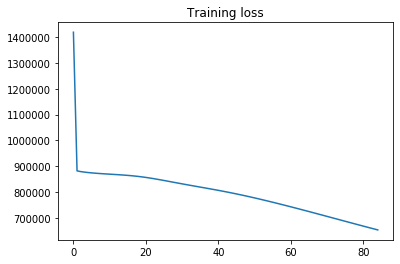

In [129]:
# define the model
model = SGDPP2()

# fit the model to the training set
model.fit(trainset)

# compute the predictions
predictions = model.test(testset)

# compute the RMSE on the testset
rmse = accuracy.rmse(predictions)